In [3]:
import numpy as np
import pandas as pd
import pickle
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, learning_curve, train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import ttest_rel
from glob import glob
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

with open('data/site_dic.pkl', 'rb') as input_file:
    site_dict = pickle.load(input_file)

# 1. Загрузка и предобработка данных

In [4]:
times = ['time{}'.format(i) for i in range(1, 11)]
sites = ['site{}'.format(i) for i in range(1, 11)]

# with open ('df_1_10_windows_list.pkl', 'rb') as fp:
#     DF = pickle.load(fp)
# df_train = DF[0]
# del DF
    
# with open ('cross_val_scores_baseline.pkl', 'rb') as fp:
#     cross_val_scores_baseline = pickle.load(fp)
    
df_train = pd.read_csv('data/train_sessions.csv', index_col='session_id')
df_test = pd.read_csv('data/test_sessions.csv', index_col='session_id')
y_train = df_train['target'].values

idx_split = len(df_train)
df_full = pd.concat([df_train.drop('target', axis=1), df_test])
df_full[sites] = df_full[sites].fillna(0).astype('int')
df_full[times] = df_full[times].fillna(0).apply(pd.to_datetime)
df_full.sort_index(axis=1, inplace=True)

# df_test.sort_index(axis=1, inplace=True)

In [4]:
df_full.head(1)

,site1,site10,site2,site3,site4,site5,site6,site7,site8,site9,time1,time10,time2,time3,time4,time5,time6,time7,time8,time9
session_id,,,,,,,,,,,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0,2014-02-20 10:02:45,1970-01-01,1970-01-01,1970-01-01,1970-01-01,1970-01-01,1970-01-01,1970-01-01,1970-01-01,1970-01-01


# 2. Визуальный анализ данных

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

**Дополнительные признаки**
- год
- месяц
- день недели
- час
- год+месяц
- час
- выходной
- день недели + час

- длина сессии
- количество уникальных сайтов в сессии
- сайт принадлежит тем, которые посещает Элис
- час в который Элис бывает

In [6]:
# bins=[0, 6, 12, 18, 24]

df_full['dow'] = df_full['time1'].apply(lambda x: x.dayofweek)
df_full['day'] = df_full['time1'].apply(lambda x: x.day)
# df_full['year_month'] = df_full['time1'].apply(lambda x: 100 * x.year + x.month)
df_full['week'] = df_full['time1'].apply(lambda x: x.week)
df_full['month'] = df_full['time1'].apply(lambda x: x.month)
df_full['hour'] = df_full['time1'].apply(lambda x: x.hour)
df_full['year'] = df_full['time1'].apply(lambda x: x.year)
# df_full['time_of_day'] = pd.cut(df_full['hour'], bins=bins, labels=list(range(len(bins)-1)), right=False)
# df_full['isweekend'] = (df_new_feat['dow'] >= 5).astype(int)
df_full['session_time'] = (df_full['time10'] - df_full['time1']).astype('timedelta64[s]').astype('int')
df_full['session_time'] = df_full['session_time'].apply(lambda x: 108000 if x<0 else x)

df_train = df_full.iloc[:idx_split, :]
df_test = df_full.iloc[idx_split:, :]
df_train['target'] = y_train

In [87]:
alices_sites = list(set(df_train[df_train.target==1][sites].stack().unique()) - set(df_train[df_train.target==0][sites].stack().unique()))

In [98]:
a = df_train[df_train.target==1][sites].stack().value_counts()
a.index[:10]

Float64Index([77.0, 80.0, 76.0, 29.0, 21.0, 81.0, 22.0, 879.0, 75.0, 82.0], dtype='float64')

### Распределение классов целевой переменной

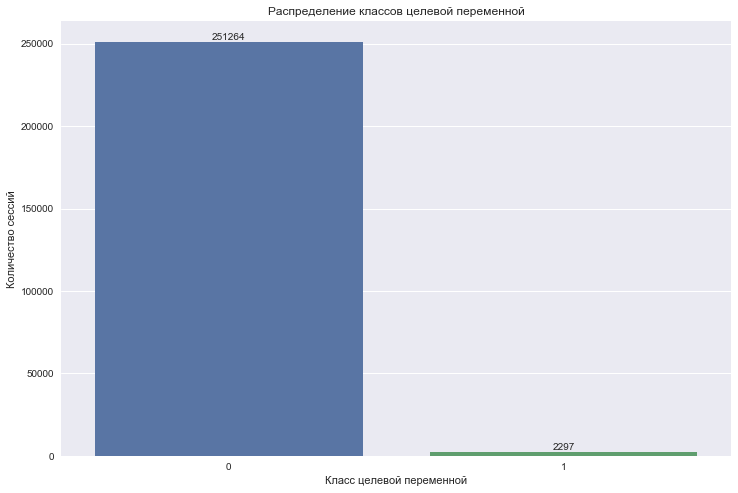

In [23]:
ax = sns.countplot(x='target', data=df_train)
ax.set(xlabel='Класс целевой переменной', ylabel='Количество сессий', title='Распределение классов целевой переменной')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

In [1]:
2297/251264

0.009141779164544065

### Распределение TRAIN и TEST по годам

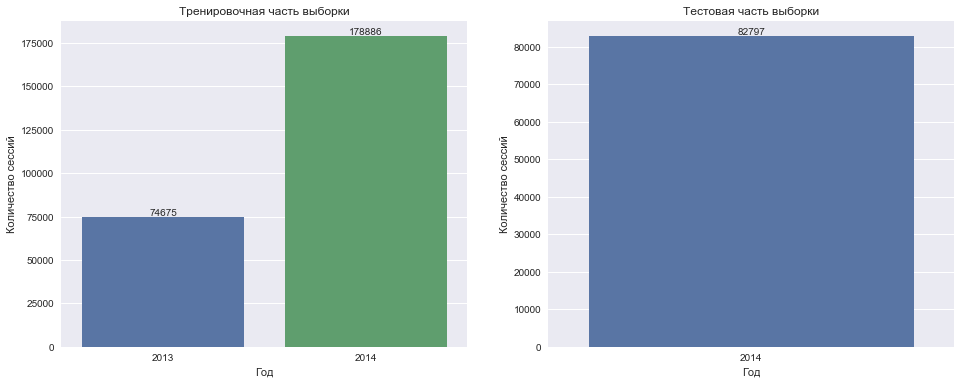

In [19]:
_, axes = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(x='year', data=df_train, ax=axes[0])
sns.countplot(x='year', data=df_test, ax=axes[1])
axes[0].set(xlabel='Год', ylabel='Количество сессий', title='Тренировочная часть выборки')
axes[1].set(xlabel='Год', ylabel='Количество сессий', title='Тестовая часть выборки')

for ax in axes:    
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

### Распределение данных по месяцам в тренировочной части выборки за 2013 год:

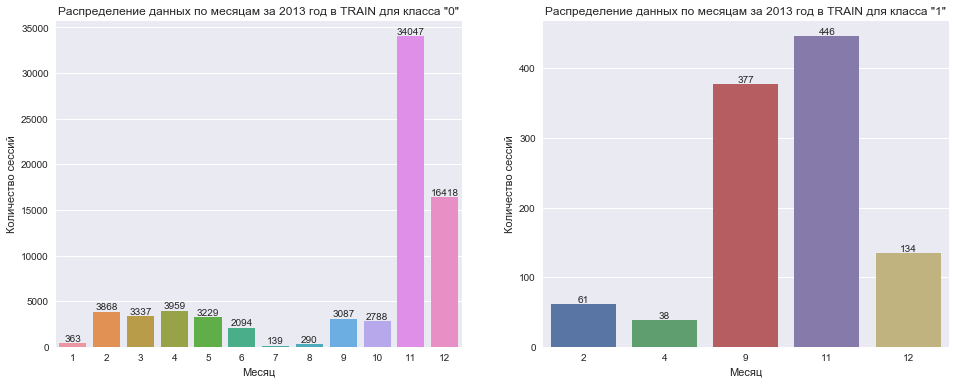

In [21]:
_, axes = plt.subplots(1, 2, figsize=(16,6))
tmp_df = df_train[(df_train.target==0)&(df_train.year==2013)]
sns.countplot('month', data=tmp_df, ax=axes[0])
tmp_df = df_train[(df_train.target==1)&(df_train.year==2013)]
sns.countplot('month', data=tmp_df, ax=axes[1])
axes[0].set(xlabel='Месяц', ylabel='Количество сессий', 
            title='Распределение данных по месяцам за 2013 год в TRAIN для класса "0"')
axes[1].set(xlabel='Месяц', ylabel='Количество сессий', 
            title='Распределение данных по месяцам за 2013 год в TRAIN для класса "1"')

for ax in axes:    
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

### Распределение данных по месяцам в тренировочной части выборки за 2014 год:

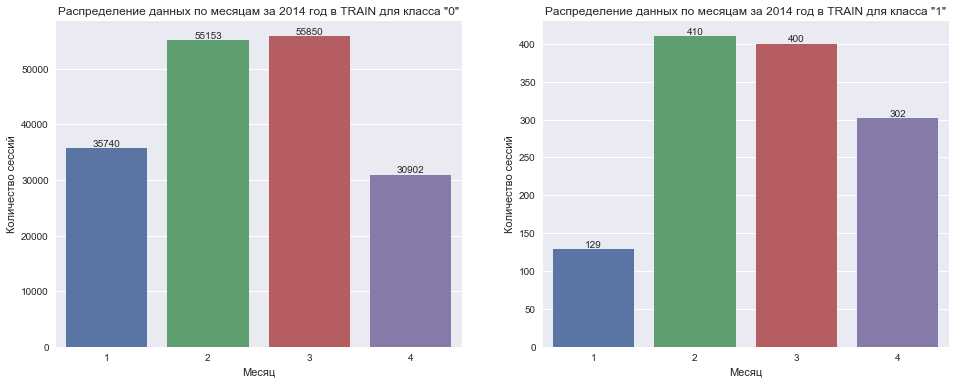

In [24]:
_, axes = plt.subplots(1, 2, figsize=(16,6))
tmp_df = df_train[(df_train.target==0)&(df_train.year==2014)]
sns.countplot('month', data=tmp_df, ax=axes[0])
tmp_df = df_train[(df_train.target==1)&(df_train.year==2014)]
sns.countplot('month', data=tmp_df, ax=axes[1])
axes[0].set(xlabel='Месяц', ylabel='Количество сессий', 
            title='Распределение данных по месяцам за 2014 год в TRAIN для класса "0"')
axes[1].set(xlabel='Месяц', ylabel='Количество сессий', 
            title='Распределение данных по месяцам за 2014 год в TRAIN для класса "1"')

for ax in axes:    
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

### Распределение данных по месяцам в тестовой части выборки:

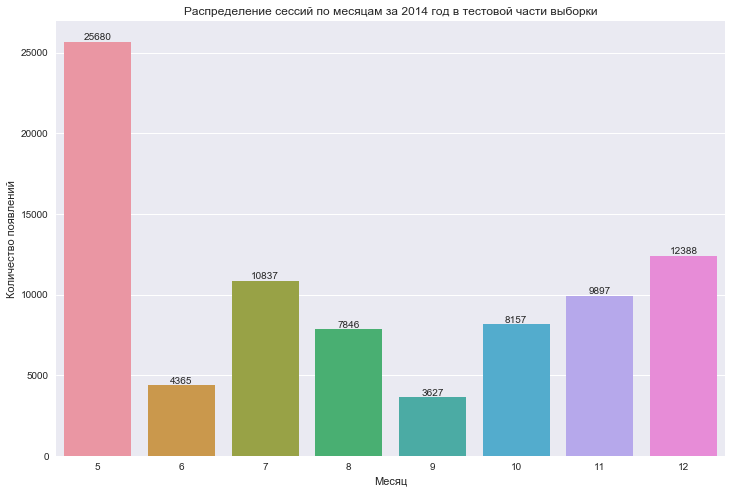

In [25]:
ax = sns.countplot('month', data=df_test)
ax.set(xlabel='Месяц', ylabel='Количество появлений', 
       title='Распределение сессий по месяцам за 2014 год в тестовой части выборки')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

### Распределение данных по часу начала сессии в тренировочной части выборки:

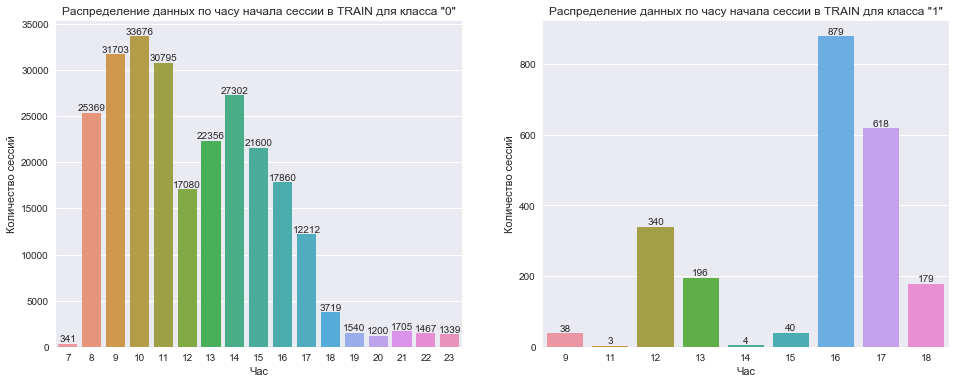

In [26]:
_, axes = plt.subplots(1, 2, figsize=(16,6))
tmp_df = df_train[df_train.target==0]
sns.countplot('hour', data=tmp_df, ax=axes[0])
tmp_df = df_train[df_train.target==1]
sns.countplot('hour', data=tmp_df, ax=axes[1])
axes[0].set(xlabel='Час', ylabel='Количество сессий', title='Распределение данных по часу начала сессии в TRAIN для класса "0"')
axes[1].set(xlabel='Час', ylabel='Количество сессий', title='Распределение данных по часу начала сессии в TRAIN для класса "1"');

for ax in axes:    
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

### Распределение данных по часу начала сессии в тестовой части выборки:

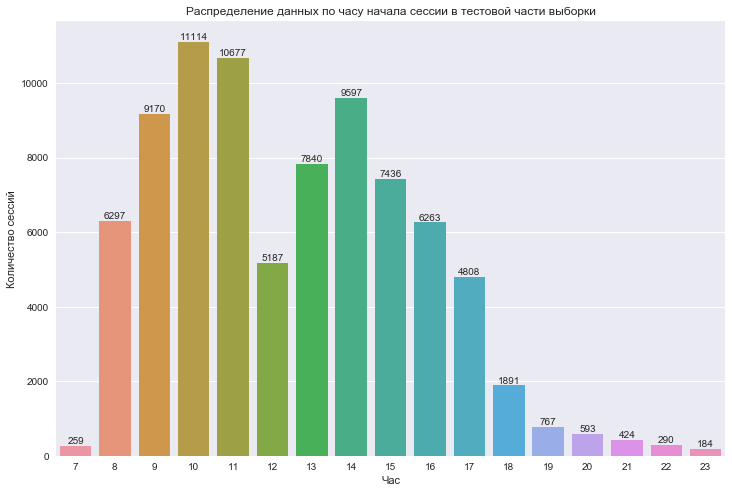

In [27]:
ax = sns.countplot('hour', data=df_test)
ax.set(xlabel='Час', ylabel='Количество сессий', 
       title='Распределение данных по часу начала сессии в тестовой части выборки')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

### Распределение данных по дню недели начала сессии в тренировочной части выборки:

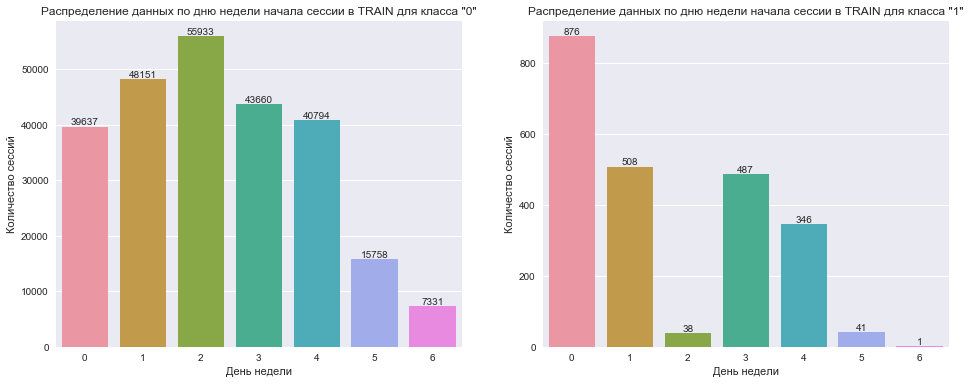

In [30]:
_, axes = plt.subplots(1, 2, figsize=(16,6))
tmp_df = df_train[df_train.target==0]
sns.countplot('dow', data=tmp_df, ax=axes[0])
tmp_df = df_train[df_train.target==1]
sns.countplot('dow', data=tmp_df, ax=axes[1])
axes[0].set(xlabel='День недели', ylabel='Количество сессий', 
            title='Распределение данных по дню недели начала сессии в TRAIN для класса "0"')
axes[1].set(xlabel='День недели', ylabel='Количество сессий', 
            title='Распределение данных по дню недели начала сессии в TRAIN для класса "1"');

for ax in axes:    
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

### Распределение данных по дню недели начала сессии в тестовой части выборки:

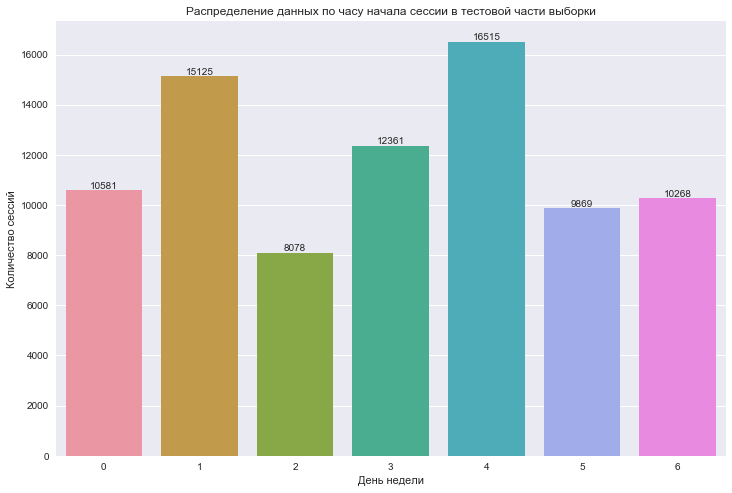

In [31]:
ax = sns.countplot('dow', data=df_test)
ax.set(xlabel='День недели', ylabel='Количество сессий', 
       title='Распределение данных по часу начала сессии в тестовой части выборки')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

### Распределение данных по дню месяца начала сессии в тренировочной части выборки:

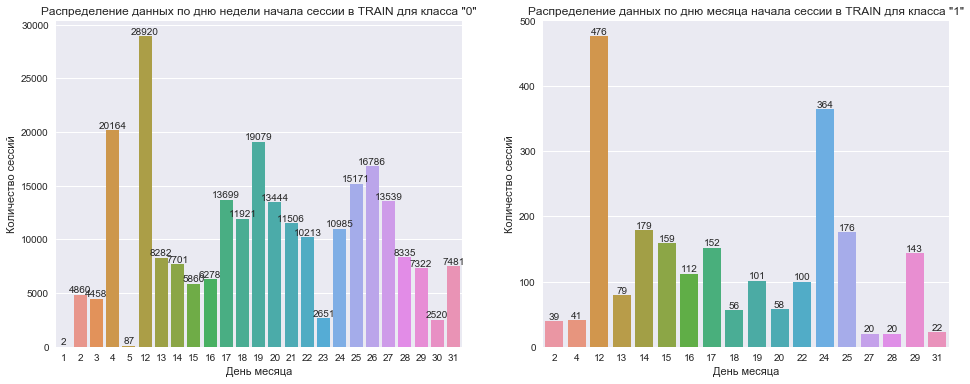

In [32]:
_, axes = plt.subplots(1, 2, figsize=(16,6))
tmp_df = df_train[df_train.target==0]
sns.countplot('day', data=tmp_df, ax=axes[0])
tmp_df = df_train[df_train.target==1]
sns.countplot('day', data=tmp_df, ax=axes[1])
axes[0].set(xlabel='День месяца', ylabel='Количество сессий', 
            title='Распределение данных по дню недели начала сессии в TRAIN для класса "0"')
axes[1].set(xlabel='День месяца', ylabel='Количество сессий', 
            title='Распределение данных по дню месяца начала сессии в TRAIN для класса "1"');

for ax in axes:    
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

### Распределение данных по дню месяца начала сессии в тестовой части выборки:

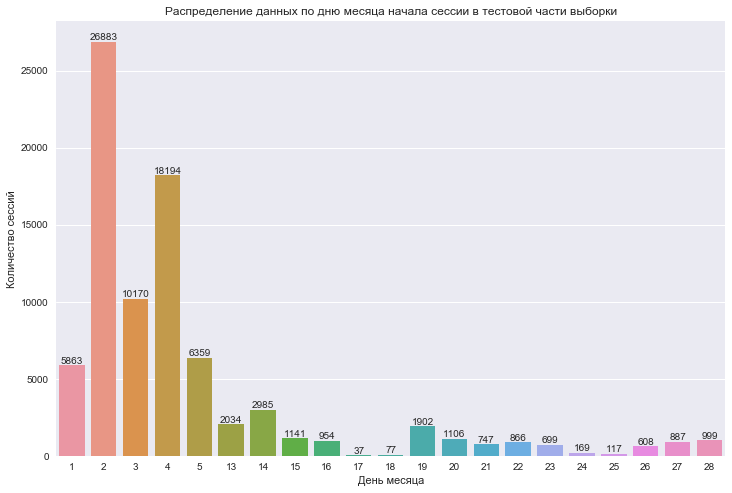

In [33]:
ax = sns.countplot('day', data=df_test)
ax.set(xlabel='День месяца', ylabel='Количество сессий', 
       title='Распределение данных по дню месяца начала сессии в тестовой части выборки')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

### Распределение данных по дню недели и часу начала сессии для класса "0" в тренировочной части выборки:

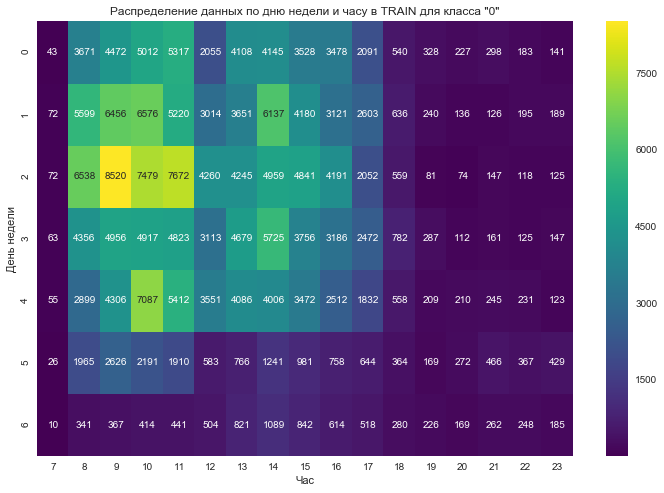

In [79]:
result = df_train[df_train.target==0].pivot_table(index='dow', columns='hour', values='target', aggfunc='count')
ax = sns.heatmap(result, annot=True, fmt='.0f', cmap='viridis')
ax.set(xlabel='Час', ylabel='День недели', 
            title='Распределение данных по дню недели и часу в TRAIN для класса "0"');

### Распределение данных по дню недели и часу начала сессии для класса "1" в тренировочной части выборки:

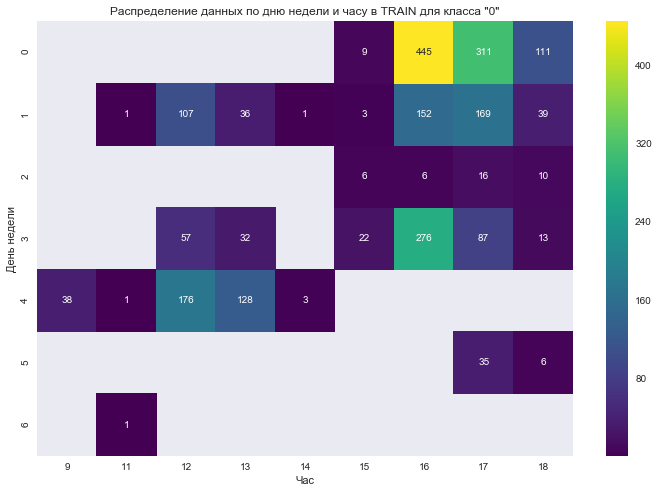

In [80]:
result = df_train[df_train.target==1].pivot_table(index='dow', columns='hour', values='target', aggfunc='count')
ax = sns.heatmap(result, annot=True, fmt='.0f', cmap='viridis')
ax.set(xlabel='Час', ylabel='День недели', 
            title='Распределение данных по дню недели и часу в TRAIN для класса "0"');

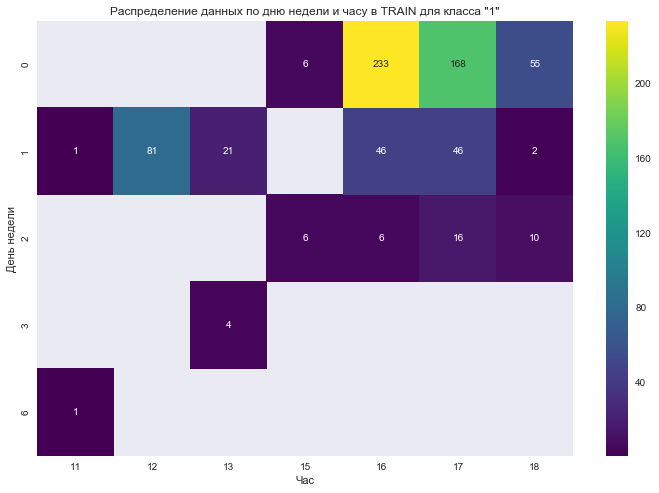

In [9]:
temp = df_train[(df_train.time1>='2014-03-01')].reset_index(drop=True)
result = temp[temp.target==1].pivot_table(index='dow', columns='hour', values='target', aggfunc='count')
ax = sns.heatmap(result, annot=True, fmt='.0f', cmap='viridis')
ax.set(xlabel='Час', ylabel='День недели', 
            title='Распределение данных по дню недели и часу в TRAIN для класса "1"');

### Распределение данных по дню недели и часу начала сессии в тестовой части выборки:

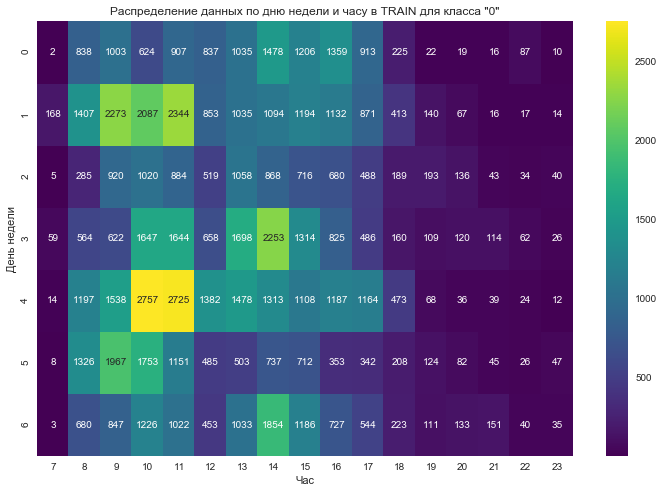

In [82]:
result = df_test.pivot_table(index='dow', columns='hour', values='day', aggfunc='count')
ax = sns.heatmap(result, annot=True, fmt='.0f', cmap='viridis')
ax.set(xlabel='Час', ylabel='День недели', 
            title='Распределение данных по дню недели и часу в TRAIN для класса "0"');

In [101]:
# idx_split = df_train.shape[0]
# df_full = pd.concat([df_train.drop('target', axis=1), df_test])
# y_train = df_train['target'].values

# CSR matrix сайтов
sites_flatten = df_full[sites].values.flatten()
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

X_train_sparse = full_sites_sparse[:idx_split]
X_test_sparse = full_sites_sparse[idx_split:]

X_train_sparse.shape, X_test_sparse.shape

((253561, 48371), (82797, 48371))

# Используемые функции

In [4]:
def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
def prepare_train_set(path_to_csv_files, WINDOW=10, DICT=site_dict):
    '''
    19.03.2018
    WINDOW - ширина скользящего окна
    DICT - словарь сайтов
    path_to_csv_files - каталог с файлами
    '''
    columns = ['site{}'.format(i) for i in range(1, 11)]+['time{}'.format(i) for i in range(1, 11)]+['target']
    FILES = glob(path_to_csv_files+'*.csv')                # список файлов
    sessions_to_df=[]                                      # список сессий, где каждая сессия - список
    for f in log_progress(FILES, every=1, name='Files'): #                                        # итерация по файлам
        user = int(1) if f.split('/')[2]=='Alice_log.csv' else int(0)    # id пользователя из имени файла
        with open(f, 'r') as user_file:                    # для каждого файла
            next(user_file)                                # пропускаем header
            session_span = 1800                            # максимальная длина сессии (30 мин)
            lst_current_session = []                           # текущая сессия
            lst_date_time = []                                 # время захода на сайт
            for line in user_file:                                   # для каждой строчки (сайта)
                ln = line.strip().split(',')                         # ln[0] - дата и время, ln[1] - имя сайта
                time = datetime.strptime(ln[0], "%Y-%m-%d %H:%M:%S")
                if len(lst_current_session)>0:   # если не первая строка файла
                    current_time_span = timedelta.total_seconds(time - lst_date_time[0])   # текущая длина сессии
                    if (current_time_span > session_span) | (len(lst_current_session)==10):  # текущий сайт уже из следующей сессии
                        nan_site_list=[0]*(10-len(lst_current_session))
                        nan_time_list=[datetime.strptime('2000-01-01 23:00:00', "%Y-%m-%d %H:%M:%S")]*(10-len(lst_current_session))
                        sessions_to_df.append(lst_current_session + nan_site_list + lst_date_time + nan_time_list + [user]) # добавляем в общий список сессий
                        if len(lst_current_session)>WINDOW:                  # если элементов текущей с больше, чем ширина окна
                            lst_current_session = lst_current_session[WINDOW:] # добавляем элементы между окном и макс длиной
                            lst_date_time = lst_date_time[WINDOW:]
                        else:
                            lst_current_session = []                             # обнуляем текущую сессию
                            lst_date_time = []
                        lst_current_session.append(DICT.get(ln[1]))  # добавляем первый сайт в сессию
                        lst_date_time.append(time)                   # добавляем первый элемент в сессию
                    else:
                        lst_current_session.append(DICT.get(ln[1]))
                        lst_date_time.append(time)
                        
                else:                                            # если первая строка файла
                    lst_current_session.append(DICT.get(ln[1]))  # добавляем первый сайт в сессию
                    lst_date_time.append(time)                   # добавляем первый элемент в сессию
                    
        if len(lst_current_session)>0: # недобавленная (неполная) сессия в конце файла 2013-01-12 15:31:16
            nan_site_list=[0]*(10-len(lst_current_session))
            nan_time_list=[datetime.strptime('2000-01-01 23:00:00', "%Y-%m-%d %H:%M:%S")]*(10-len(lst_current_session))
            sessions_to_df.append(lst_current_session + nan_site_list + lst_date_time + nan_time_list + [user])
               
    return pd.DataFrame(sessions_to_df, columns=columns)    

# Обработка сырых данных

In [4]:
%%time
DF = []
for window in log_progress(range(1,11), every=1, name='Window'): 
    DF.append(prepare_train_set('data/users/', WINDOW=window, DICT=site_dict))
    
with open('df_1_10_windows_list.pkl', 'wb') as fp:
    pickle.dump(DF, fp)

CPU times: user 13min 17s, sys: 41.2 s, total: 13min 58s
Wall time: 16min 43s


In [9]:
DF[0].time10.min()

Timestamp('2000-01-01 23:00:00')

In [ ]:
times = ['time{}'.format(i) for i in range(1, 11)]
df_train = DF[0][sites].fillna(0).astype('int')

In [5]:
for i in range(len(DF)):
    print(DF[i].shape)

(2399030, 21)
(1201659, 21)
(803194, 21)
(605206, 21)
(488287, 21)
(409834, 21)
(354130, 21)
(312152, 21)
(279700, 21)
(253561, 21)


In [9]:
cross_val_scores_baseline = []

sites = ['site{}'.format(i) for i in range(1, 11)]

for i in log_progress(range(len(DF)), every=1, name='Window'):
    df_train = DF[i][sites].fillna(0).astype('int')
    sites_flatten = df_train.values.flatten()
    X_train = csr_matrix(([1] * sites_flatten.shape[0], sites_flatten, range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]
    y_train = DF[i].target.values
    cross_val_scores_baseline.append(cross_val_score(logit, X_train, y_train, cv=skf, scoring='roc_auc'))

    print('Window={}, mean ROC AUC: {}, std ROC AUC: {}'.format(i+1, 
                            '%.6f' % cross_val_scores_baseline[i].mean(), '%.6f' % cross_val_scores_baseline[i].std()))
    
with open('cross_val_scores_baseline.pkl', 'wb') as fp:
    pickle.dump(cross_val_scores_baseline, fp)

Window=1, mean ROC AUC: 0.982759, std ROC AUC: 0.000450
Window=2, mean ROC AUC: 0.980645, std ROC AUC: 0.000606
Window=3, mean ROC AUC: 0.978829, std ROC AUC: 0.000835
Window=4, mean ROC AUC: 0.977111, std ROC AUC: 0.001363
Window=5, mean ROC AUC: 0.974170, std ROC AUC: 0.000667
Window=6, mean ROC AUC: 0.973546, std ROC AUC: 0.001972
Window=7, mean ROC AUC: 0.972003, std ROC AUC: 0.001014
Window=8, mean ROC AUC: 0.969112, std ROC AUC: 0.001489
Window=9, mean ROC AUC: 0.968794, std ROC AUC: 0.002488
Window=10, mean ROC AUC: 0.963982, std ROC AUC: 0.001773


# Окно 5

In [4]:
RANDOM_STATE = 17
logit = LogisticRegression(C=1.0, random_state=RANDOM_STATE, n_jobs=-1)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [10]:
!df -m

Filesystem                                                     1M-blocks     Used Available Use% Mounted on
none                                                             1023499    75173    948326   8% /
tmpfs                                                              32118        0     32118   0% /dev
tmpfs                                                              32118        0     32118   0% /sys/fs/cgroup
/dev/xvdc1                                                       1023499    75173    948326   8% /.r
10.114.124.136:/mnt/disk1/production/dmitpetukhov               45598671 30276598  13033007  70% /resources
shm                                                                   64       54        11  84% /dev/shm
10.114.124.136:/mnt/disk1/production/dmitpetukhov/.log/jupyter  45598671 30276598  13033007  70% /var/log/supervisor
tmpfs                                                              32118        0     32118   0% /sys/firmware


In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)


n_train, val_train, val_test = learning_curve(logit, X_train_sparse, y_train, train_sizes=train_sizes, cv=skf,
                                             scoring='roc_auc', random_state=17, n_jobs=-1)
plt.figsize=(20, 10)
plot_learning_curve(val_train, val_test, n_train, xlabel='train_size', ylabel='ROC-AUC', n_jobs=-1)

In [29]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

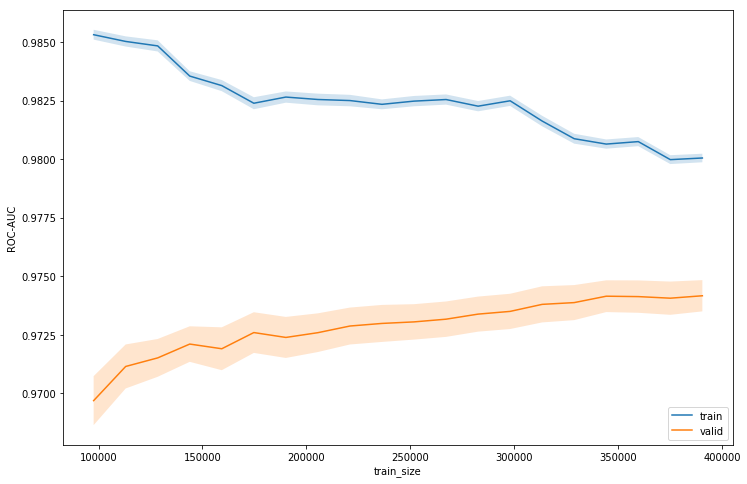

In [30]:
plt.figsize=(20, 10)
plot_learning_curve(val_train, val_test, n_train, xlabel='train_size', ylabel='ROC-AUC')

# Создание признаков

In [5]:
def prepare_site_dict(df):
    columns = ['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10']
    vals, cnts = np.unique(df[columns].fillna(0).values, return_counts=True)
    site_dict = dict(zip(vals.astype(int), cnts.astype(int)))
    if 0 in site_dict:
        del site_dict[0]
    return site_dict

site_freq_alice = prepare_site_dict(df_full)

In [11]:
def prepare_train_set_with_fe(df):
    df_new_feat = pd.DataFrame(index=df.index)
    
    session_window = 10
    
    time_diff = np.zeros( (df.shape[0], (session_window - 1)), dtype=int)
    session_timespan = []
    num_of_unique_sites = []
    start_hour = []
    day_of_week = []
    
    site_cols = ['site%d' % i for i in range(1, 11)]
    time_cols = ['time%d' % i for i in range(1, 11)]
    
    site_list = df[site_cols].values.tolist()
    
    for i, (_, times) in enumerate(df[time_cols].iterrows()):
        sites = site_list[i]
        times_wo_na_df = times.dropna()

        # Fill time_diff FEATURE list
        for j in range(session_window - 1):
            if not pd.isnull(times[j]) and not pd.isnull(times[j + 1]):
                time_diff[i][j] = int( (times[j + 1] - times[j]) / np.timedelta64(1, 's') )
            else:
                break

        # Fill start_hour FEATURE list
        start_hour.append(times_wo_na_df.min().hour)

        # Fill day_of_week FEATURE list
        day_of_week.append(times_wo_na_df.min().dayofweek)

        # Fill num_of_unique_sites FEATURE list
        unique_sites = set(sites)
        try:
            # remove site '0' (no visit) from session
            unique_sites.remove(0)
        except:
            pass
        num_of_unique_sites.append(len(unique_sites))
    
    # Convert features to np.array and adding them to the dataframe
    X_td = np.array(time_diff)
    time_diff_cols = ['time_diff%d' % i for i in range(1, 10)]
    X_td_df = pd.DataFrame(X_td, index=df_new_feat.index, columns=time_diff_cols)
    df_new_feat = pd.concat([df_new_feat, X_td_df], axis=1)
    
    X_nous = np.array(num_of_unique_sites)
    df_new_feat['num_of_unique_sites'] = X_nous
    
    X_sh = np.array(start_hour)
    df_new_feat['start_hour'] = X_sh
    
    X_dow = np.array(day_of_week)
    df_new_feat['day_of_week'] = X_dow
    
    # Convert 'time1' to [year][month] FEATURE (ex. 2017-02 -> 201702)
    df_new_feat['year_month_to_num'] = df['time1'].apply(lambda x: 100*x.year + x.month)
    
    return df_new_feat

In [4]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336358 entries, 0 to 82797
Data columns (total 20 columns):
site1     336358 non-null int64
site10    336358 non-null int64
site2     336358 non-null int64
site3     336358 non-null int64
site4     336358 non-null int64
site5     336358 non-null int64
site6     336358 non-null int64
site7     336358 non-null int64
site8     336358 non-null int64
site9     336358 non-null int64
time1     336358 non-null datetime64[ns]
time10    336358 non-null datetime64[ns]
time2     336358 non-null datetime64[ns]
time3     336358 non-null datetime64[ns]
time4     336358 non-null datetime64[ns]
time5     336358 non-null datetime64[ns]
time6     336358 non-null datetime64[ns]
time7     336358 non-null datetime64[ns]
time8     336358 non-null datetime64[ns]
time9     336358 non-null datetime64[ns]
dtypes: datetime64[ns](10), int64(10)
memory usage: 53.9 MB


In [4]:
df_new_feat = pd.DataFrame(index=df_full.index)
bins=[0, 6, 12, 18, 24]


df_new_feat['dow'] = df_full['time1'].apply(lambda x: x.dayofweek)
df_new_feat['year_month'] = df_full['time1'].apply(lambda x: 100 * x.year + x.month)
df_new_feat['week'] = df_full['time1'].apply(lambda x: x.week)
df_new_feat['month'] = df_full['time1'].apply(lambda x: x.month)
df_new_feat['hour'] = df_full['time1'].apply(lambda x: x.hour)
df_new_feat['year'] = df_full['time1'].apply(lambda x: x.year)
df_new_feat['time_of_day'] = pd.cut(df_new_feat['hour'], bins=bins, labels=list(range(len(bins)-1)), right=False)
df_new_feat['isweekend'] = (df_new_feat['dow'] >= 5).astype(int)
df_new_feat['session_time'] = (df_full['time10'] - df_full['time1']).astype('timedelta64[s]').astype('int')
df_new_feat['session_time'] = df_new_feat['session_time'].apply(lambda x: 108000 if x<0 else x)

df_new_feat.shape

(336358, 9)

In [11]:
df_new_feat.tail()

,dow,year_month,month,hour,year,time_of_day,isweekend
82793,3,201410,10,18,2014,3,0
82794,0,201405,5,14,2014,2,0
82795,4,201405,5,11,2014,1,0
82796,5,201405,5,10,2014,1,1
82797,6,201411,11,10,2014,1,1


In [5]:
df_new_feat['session_time'] = np.log1p(df_new_feat['session_time'].values)
feat_to_ohe = ['dow', 'month', 'hour','year_month', 'week', 'time_of_day'] #,'year_month', 'week', 'time_of_day']
dummies = pd.get_dummies(df_new_feat, columns = feat_to_ohe, 
               prefix=['col_{}'.format(i) for i in range(len(feat_to_ohe))], sparse=False)

df_new_feat_train = dummies.iloc[:idx_split, :]
df_new_feat_test = dummies.iloc[idx_split:, :]

X_train_sparse_new = csr_matrix(hstack([X_train_sparse, df_new_feat_train]))
X_test_sparse_new = csr_matrix(hstack([X_test_sparse, df_new_feat_test]))
X_train_sparse_new.shape, X_test_sparse_new.shape

((253561, 48480), (82797, 48480))

# Подбор моделей и кросс-валидация

In [104]:
RANDOM_STATE = 17
sgd = SGDClassifier(loss='log', random_state=RANDOM_STATE, n_jobs=-1)
# logit = LogisticRegression(C=1.0, random_state=RANDOM_STATE, n_jobs=-1, class_weight={0: 0.1, 1: 0.9})

skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
%%time
sm = SMOTE(random_state=RANDOM_STATE, ratio='minority', n_jobs=1)
X, y = sm.fit_sample(X_train_sparse_new, y_train)

In [8]:
X.shape

(4752540, 48438)

In [105]:
%%time
score = cross_val_score(sgd, X_train_sparse, y_train, cv=skf, scoring='roc_auc')
print(np.round(score.mean(), 6), np.round(score.std(), 6))

0.940383 0.005145
Wall time: 6.88 s


In [29]:
print(np.round(score.mean(), 6), np.round(score.std(), 6))

0.991957 0.001984


In [ ]:
(array([0.99754529, 0.99758831, 0.9974137 , 0.99777928, 0.998014  ]),
 0.9976681150883312)

# Статистическая значимость

In [2]:
df_train = pd.read_csv('data/train_sessions.csv', index_col='session_id')
df_test = pd.read_csv('data/test_sessions.csv', index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time{}'.format(i) for i in range(1, 11)]
df_train[times] = df_train[times].apply(pd.to_datetime)
df_test[times] = df_test[times].apply(pd.to_datetime)
y = df_train['target'].values

# Разбиваем на сайты и остальные признаки    
df_sites_train = df_train[['site{}'.format(i) for i in range(1, 11)]]

df_feat_train = df_train[df_train.columns[~df_train.columns.str.startswith('site')]]

df_sites_test = df_test[['site{}'.format(i) for i in range(1, 11)]].fillna(0).astype('int')
df_feat_test = df_test[df_test.columns[~df_test.columns.str.startswith('site')]] 

# CSR matrix сайтов
idx_split = df_train.shape[0]
sites_flatten = pd.concat([df_sites_train, df_sites_test]).values.flatten()
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

X_train_sparse = full_sites_sparse[:idx_split]
X_test_sparse = full_sites_sparse[idx_split:]

X_train_sparse.shape, X_test_sparse.shape, df_feat_train.shape, df_feat_test.shape

((253561, 48371), (82797, 48371), (253561, 11), (82797, 10))

# Новые признаки

In [3]:
RANDOM_STATE = 17
sgd = SGDClassifier(loss='log', random_state=RANDOM_STATE, n_jobs=-1)
logit = LogisticRegression(C=3.94947, random_state=RANDOM_STATE, n_jobs=-1)
svc = SVC(random_state=RANDOM_STATE)

# scaler = StandardScaler()

# def get_auc_valid(estimator, X1=X_train_sparse, X2=new_feat_train, seed=RANDOM_STATE):
#     '''
#     X1 – csr матрица сайтов
#     C, seed – коэф-т регуляризации и random_state 
#               логистической регрессии
#     '''
   
#     X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.3, 
#                                                                              shuffle=False, random_state=seed)
#     X2_train = scaler.fit_transform(X2_train[X2.columns.tolist()])
#     X2_test = scaler.transform(X2_test[X2.columns.tolist()])
    
#     X_train = csr_matrix(hstack([X1_train, X2_train]))
#     X_test = csr_matrix(hstack([X1_test, X2_test]))
   
#     return round(roc_auc_score(y_test, estimator.fit(X_train, y_train).predict_proba(X_test)[:, 1]), 4)

# Cross-Validation

In [17]:
logit1_params = {}
logit1 = LogisticRegression(C=1.0, random_state=RANDOM_STATE, n_jobs=-1)
logit2 = LogisticRegression(C=3.94947, random_state=RANDOM_STATE, n_jobs=-1)

In [23]:
new_feat_train_1 = pd.DataFrame(index=df_train.index)
new_feat_train_2 = pd.DataFrame(index=df_train.index)
bins=[0, 6, 12, 18, 24]
feat_to_ohe = ['dow','month','hour','year','time_of_day']

new_feat_train_1['dow'] = df_train['time1'].apply(lambda x: x.dayofweek)
new_feat_train_1['month'] = df_train['time1'].apply(lambda x: x.month)
new_feat_train_1['hour'] = df_train['time1'].apply(lambda x: x.hour)
new_feat_train_1['year'] = df_train['time1'].apply(lambda x: x.year)
new_feat_train_1['time_of_day'] = pd.cut(new_feat_train_1['hour'], bins=bins, labels=list(range(len(bins)-1)), right=False)
new_feat_train_1['isweekend'] = (new_feat_train_1['dow'] >= 5).astype(int)

new_feat_train_1 = pd.get_dummies(new_feat_train_1, columns = feat_to_ohe, 
                                  prefix=['col_{}'.format(i) for i in range(len(feat_to_ohe))], sparse=False)
X_train_sparse_1 = csr_matrix(hstack([X_train_sparse, new_feat_train_1]))



new_feat_train_2 = pd.DataFrame(index=df_train.index)

new_feat_train_2['dow'] = df_train['time1'].apply(lambda x: x.dayofweek)
new_feat_train_2['month'] = df_train['time1'].apply(lambda x: x.month)
new_feat_train_2['hour'] = df_train['time1'].apply(lambda x: x.hour)
new_feat_train_2['year'] = df_train['time1'].apply(lambda x: x.year)
new_feat_train_2['time_of_day'] = pd.cut(new_feat_train_2['hour'], bins=bins, labels=list(range(len(bins)-1)), right=False)
new_feat_train_2['isweekend'] = (new_feat_train_2['dow'] >= 5).astype(int)

new_feat_train_2 = pd.get_dummies(new_feat_train_2, columns = feat_to_ohe, 
                                  prefix=['col_{}'.format(i) for i in range(len(feat_to_ohe))], sparse=False)
X_train_sparse_2 = csr_matrix(hstack([X_train_sparse, new_feat_train_2]))

new_feat_train_1.shape, new_feat_train_2.shape

((253561, 42), (253561, 43))

In [25]:
%%time
scores_1 = np.array([])
scores_2 = np.array([])
seeds=[1, 17, 42, 54, 78, 89, 95, 101, 123, 321]
for i in seeds:
    fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    scores_1_on_this_split = cross_val_score(estimator=logit2,
                                             X=X_train_sparse_1, y=y,
                                             cv=fold, scoring='roc_auc')
    scores_1 = np.append(scores_1, scores_1_on_this_split)

    scores_2_on_this_split = cross_val_score(estimator=logit2,
                                             X=X_train_sparse_2, y=y,
                                             cv=fold, scoring='roc_auc')
    scores_2 = np.append(scores_2, scores_2_on_this_split)

print(ttest_rel(scores_1, scores_2)[0], ttest_rel(scores_1, scores_2)[1]) # если >0, то scores_1 лучше scores_2

-1.9350675678837346 0.05876487534840994
CPU times: user 16min 43s, sys: 2.88 s, total: 16min 45s
Wall time: 16min 46s


In [26]:
np.mean(scores_1), np.mean(scores_2)

(0.9901493917435336, 0.990151678583118)

In [15]:
np.std(scores_1), np.std(scores_2)

(0.0034258992289124754, 0.0020092313772475277)

In [7]:
%%time
# logit_c_values = np.linspace(3.5, 4.5, 100)
logit_c_values = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=17)
logit_grid_searcher = LogisticRegressionCV(Cs=logit_c_values, cv=cv, random_state=17, n_jobs=-1, scoring='roc_auc')
logit_grid_searcher.fit(X_train_sparse_2, y)

CPU times: user 7.33 s, sys: 6.2 s, total: 13.5 s
Wall time: 1min 1s


In [8]:
logit_mean_cv_scores = np.zeros(len(logit_c_values))
for i in logit_grid_searcher.scores_[1]: # для каждого фолда
    logit_mean_cv_scores  += np.array(i)          
logit_mean_cv_scores = logit_mean_cv_scores / 7            # среднее одного С
# logit_mean_cv_scores, logit_grid_searcher.Cs_[logit_mean_cv_scores.argmax()]
logit_mean_cv_scores

array([0.98950934, 0.9898539 , 0.99002011, 0.99010988, 0.99015533,
       0.99017346, 0.99018281, 0.99017923, 0.99016857])

In [9]:
logit_mean_cv_scores.max(), logit_grid_searcher.Cs_[logit_mean_cv_scores.argmax()]

(0.9901828061006009, 4.0)

In [10]:
logit_grid_searcher.Cs_

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [ ]:
(0.9901833132389967, 3.9494736842105262)
(0.9904066458202052, 3.5)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_train_sparse, y, test_size=0.3, 
                                                                             shuffle=False, random_state=RANDOM_STATE)
    
round(roc_auc_score(y_test, logit.fit(X_train, y_train).predict_proba(X_test)[:, 1]), 4)

0.95830000000000004

In [23]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X_train_sparse, new_feat_train, y, test_size=0.3, 
                                                                             shuffle=False, random_state=RANDOM_STATE)
X2_train = scaler.fit_transform(X2_train[new_feat_train.columns.tolist()])
X2_test = scaler.transform(X2_test[new_feat_train.columns.tolist()])
    
X_train = csr_matrix(hstack([X1_train, X2_train]))
X_test = csr_matrix(hstack([X1_test, X2_test]))
   
round(roc_auc_score(y_test, sgd.fit(X_train, y_train).predict_proba(X_test)[:, 1]), 4)

0.95679999999999998

In [16]:
get_auc_valid(estimator=logit)

0.97089999999999999

In [17]:
get_auc_valid(estimator=sgd)

0.95150000000000001

# Обучение

In [17]:
X_tr, X_v, y_tr, y_v = train_test_split(X_train_sparse_new, y_train,
                                                      test_size=0.25, shuffle=True, random_state=17, stratify=y_train)

In [18]:
y_pred_logit = logit.fit(X_tr, y_tr).predict_proba(X_v)[:,1]
y_pred_sgd = sgd.fit(X_tr, y_tr).predict_proba(X_v)[:,1]

In [19]:
y_pred_sgd

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
roc_auc_score(y_v, y_pred_logit)

0.9923485225791927

In [38]:
roc_auc_score(y_v, y_pred_svm)

0.5

In [26]:
for i in [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]:
    predict = i*y_pred_logit + (1-i)*y_pred_sgd
    print(round(roc_auc_score(y_v, predict), 8))

0.99234852
0.99234852
0.99234852
0.99234852
0.99234852
0.99234852
0.99234852
0.99234852
0.99234852
0.99234852
0.5


In [ ]:
c1*sgd_logit_valid_pred_proba[:, 1] + (1 - c1)*logit_valid_pred_proba[:, 1]

In [23]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [21]:
logit = LogisticRegression(C=0.39, random_state=RANDOM_STATE, class_weight={0: 0.1, 1: 0.9}, n_jobs=-1)
sgd = SGDClassifier(loss='log', random_state=RANDOM_STATE, n_jobs=-1)

In [24]:
write_to_submission_file(y_pred, 'submission.csv')

In [12]:
balance_grid_searcher.best_params_

{'class_weight': {0: 0.1, 1: 0.9}}